# ARIMA model  
references:
1. [seasonal arima with python](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)  


## Deal with outliers and missing values 
[3 way to remove outliers from your data](https://ocefpaf.github.io/python4oceanographers/blog/2015/03/16/outlier_detection/)  


## The process 
1. visualize the time series
2. stationarize the series
3. Plot ACF/PACF charts and find optimal parameters
4. build the ARIMA model
5. make predictions


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose


c:\python27\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#preprocess data

df=pd.read_csv('data/portland-oregon-average-monthly-.csv',index_col=0)

start=datetime.datetime.strptime('1973-01-01','%Y-%m-%d')
date_list=[start+relativedelta(months=x) for x in range(114)]
df.index=date_list
df.head()

,riders
1973-01-01,648
1973-02-01,646
1973-03-01,639
1973-04-01,654
1973-05-01,630


## Visualize the data:  
We first want to visualize the data to understand what type of model we should use.


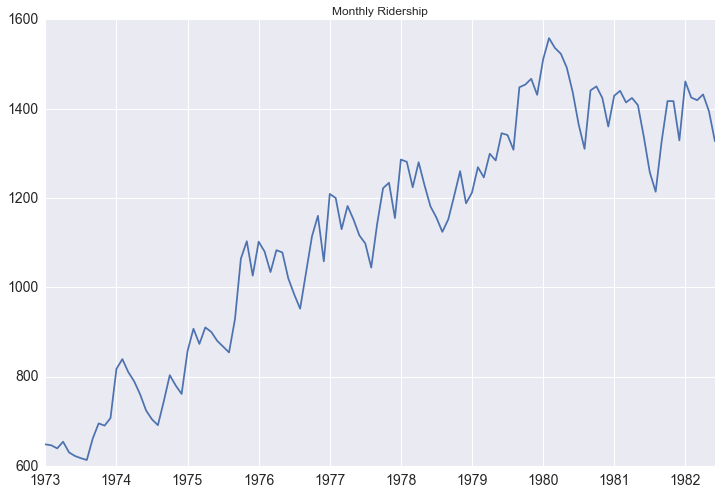

In [3]:
df.riders.plot(figsize=(12,8),title='Monthly Ridership',fontsize=14)
# plt.savefig('month_ridership.png',bbox_inches='tight')

The easiest way to observe the data is to use ``statsmodels.tsa.seasonal.seasonal_decompose``.With this,the trend and seasonality become even more obvious.

c:\python27\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


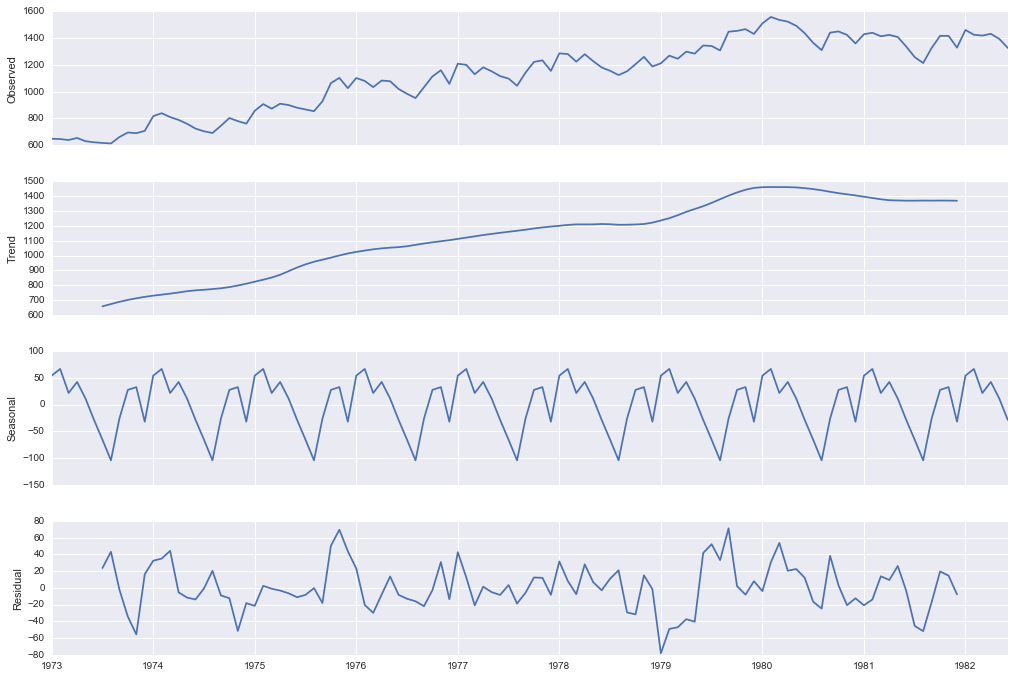

In [4]:
decomposition=seasonal_decompose(df.riders,freq=12)
fig=plt.figure()
fig=decomposition.plot()
fig.set_size_inches(15,10)

## Stationarize the data:  
What does it mean for data to be stationary?  
1. The mean of the series should not be a function of time
2. The variance of the series should not be a function of time
3. The covariance of teh i th term and the (i+m) th term should not be a funcion of time  

Why is this important?  
When running a linear regression the assumption is that all of the observations are all independent of each other.In a series,however,we know that observations are time dependent.It turns out that a lot of nice results that hold for independent random variables hold for stationary random variables.So by making the data stationary,we can actually apply regression techniques to this time dependent variable.  

Two ways to check the stationarity of a time series:
* visualizing the data to identify the changing mean or variation in the data.
* Dickey-Fuller for a more accurate assessment.


In [5]:
#visualize the data,and test for the stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts):
    
    #Determing rolling statistics
    roll=ts.rolling(12)
    rolmean=roll.mean()
    rolstd=roll.std()
    
    #plot rolling statistics
    fig=plt.figure(figsize=(12,8))
    orig=plt.plot(ts,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling & Standard Deviation')
    plt.show()
    
    #Perform Dicky-Fuller test
    print 'Results of Dicky-Fuller Test:'
    dftest=adfuller(ts,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value',
                                         '#Lags Used','Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print dfoutput

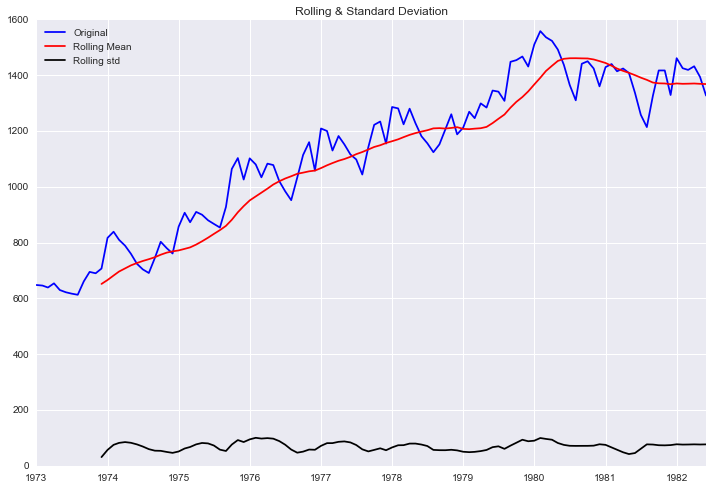

Results of Dicky-Fuller Test:
Test Statistic                 -1.536597
p-value                         0.515336
#Lags Used                     12.000000
Number of Observation Used    101.000000
Critical Value (5%)            -2.890611
Critical Value (1%)            -3.496818
Critical Value (10%)           -2.582277
dtype: float64


In [6]:
test_stationarity(df.riders)

From the *p-value* which is larger than 5% we can easily see that the time series is not stationary,and our test_stationarity function confirms what we see.  

So now we need to transform the data to make it more stationary.There are various transformations you can do to stationarize the data.
1. Deflation by CPI
2. Logarithmic
3. First Difference
4. Seaonal Difference
5. Seasonal Adjustment

You can read more [here](http://people.duke.edu/~rnau/whatuse.htm) about when to use which.  

The first thing we want to do is take a first difference of the data.This should help to eliminate the overall trend from the data.

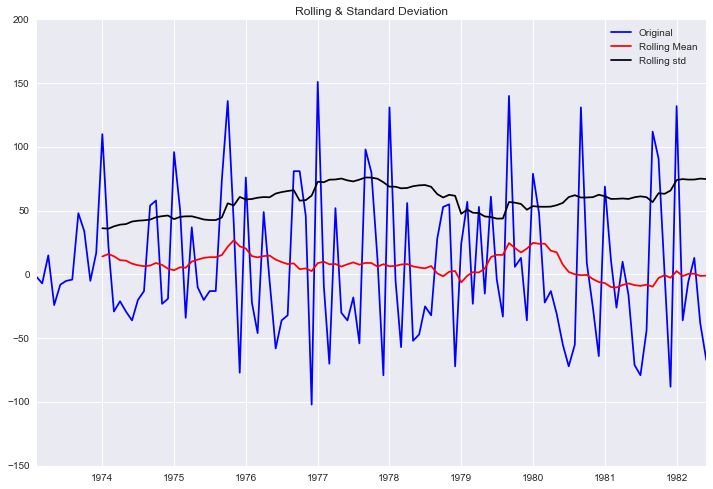

Results of Dicky-Fuller Test:
Test Statistic                 -1.938696
p-value                         0.314082
#Lags Used                     11.000000
Number of Observation Used    101.000000
Critical Value (5%)            -2.890611
Critical Value (1%)            -3.496818
Critical Value (10%)           -2.582277
dtype: float64


In [7]:
df['first_difference']=df.riders-df.riders.shift(1)
test_stationarity(df.first_difference.dropna(inplace=False))

While this helped to improve the stationarity of the data it is not there yet.Our next step is to take a seaonal difference to remove the seasonality of the data and see how that impacts the stationarity of the data.

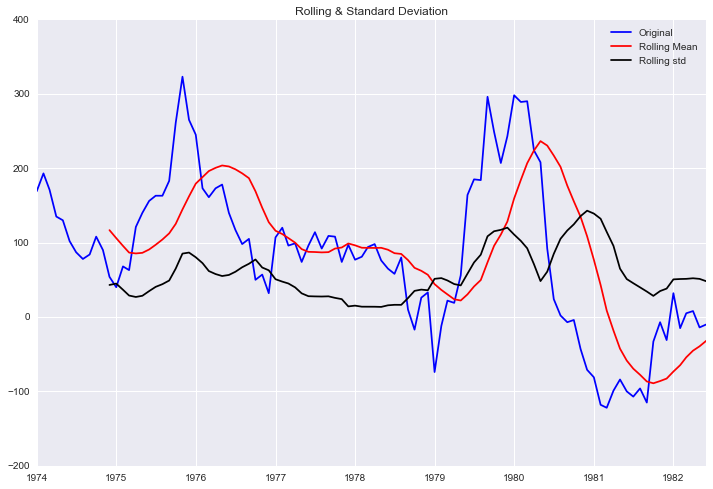

Results of Dicky-Fuller Test:
Test Statistic                -2.469741
p-value                        0.123011
#Lags Used                     3.000000
Number of Observation Used    98.000000
Critical Value (5%)           -2.891516
Critical Value (1%)           -3.498910
Critical Value (10%)          -2.582760
dtype: float64


In [8]:

df['seasonal_difference']=df.riders-df.riders.shift(12)
test_stationarity(df['seasonal_difference'].dropna())

Compared to the original data this is an improvement,but we are not there yet.The next step is to take a first diffence of the seasonal difference.

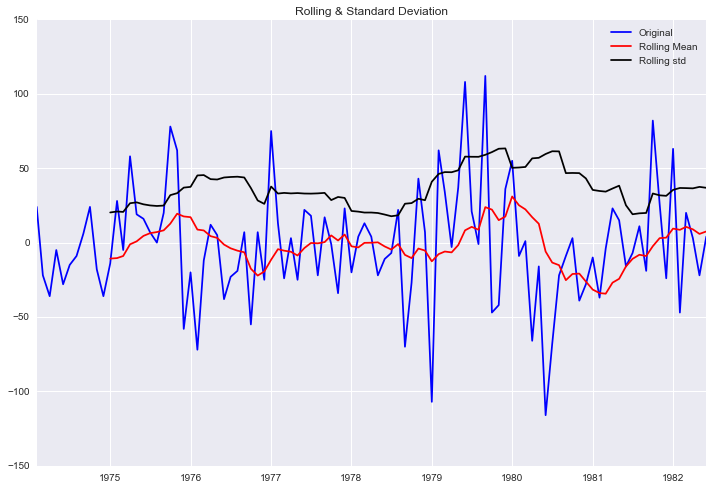

Results of Dicky-Fuller Test:
Test Statistic               -9.258520e+00
p-value                       1.427874e-15
#Lags Used                    0.000000e+00
Number of Observation Used    1.000000e+02
Critical Value (5%)          -2.890906e+00
Critical Value (1%)          -3.497501e+00
Critical Value (10%)         -2.582435e+00
dtype: float64


In [9]:
df['seasonal_first_difference']=df.first_difference-df.first_difference.shift(12)
test_stationarity(df.seasonal_first_difference.dropna())

As you can see by the p-value,taking the seasonal first difference has now made our data stationary.  

## Plot the ACF and PACF charts and find the optimal parameters  
The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs.There are many [rules and best practices](http://people.duke.edu/~rnau/arimrule.htm) about how to select the appropriate AR,MA,SAR,and MAR terms for the model.

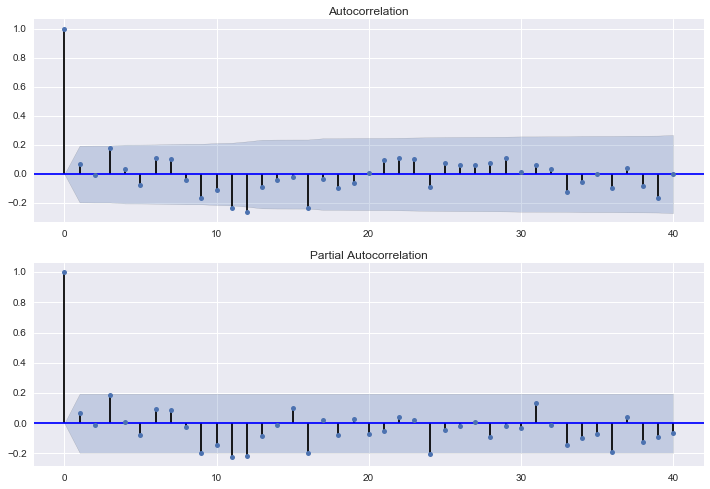

In [10]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
ifg=sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:],lags=40,ax=ax2)

Because the autocorrelation of the differenced series is negative at lag 12,I should add an AMA term to the model.

## build model  
Now that we know the parameters for the model (0,1,0)x(1,1,1,12),actually building it is quite easy.